# 32x32 Array size, 22 nm


### 32x32 Array Sizes, 22 nm



Available DNNs: ['vision_transformer', 'dpt_large', 'resnet18', 'mobilebert', 'msft_phi_1_5', 'gpt2_medium', 'vgg16', 'mobilenet_v3', 'alexnet', 'densenet201']
Running: 00 /home/workspace/scripts/../outputs/vgg16_32_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_32_RRAM_de/vgg16_32_RRAM_de_layer_1
Computes: 169344.0
01 /home/workspace/scripts/../outputs/vgg16_32_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_32_RRAM_de/vgg16_32_RRAM_de_layer_2
Computes: 3612672.0
02 /home/workspace/scripts/../outputs/vgg16_32_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_32_RRAM_de/vgg16_32_RRAM_de_layer_3
Computes: 1806336.0
03 /home/workspace/scripts/../outputs/vgg16_32_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_32_RRAM_de/vgg16_32_RRAM_de_layer_4
Computes: 3612672.0
04 /home/workspace/scripts/../outputs/vgg16_32_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_32_RRAM_de/vgg16_32_RRAM_de_layer_5
Compute

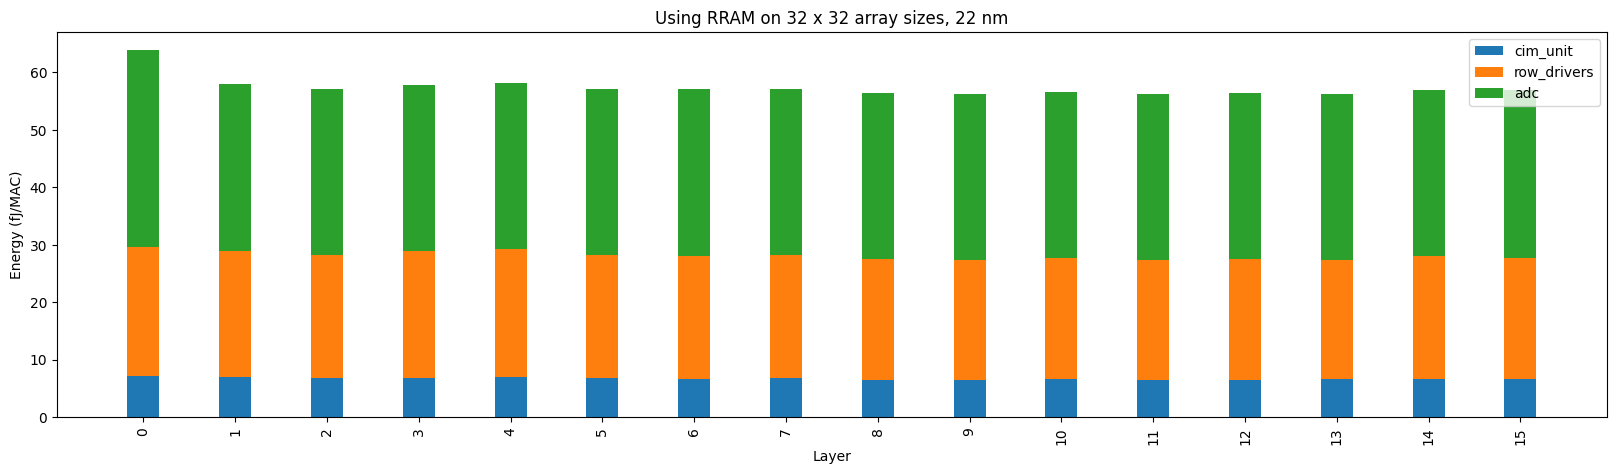

In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *
from scripts.tl_output_parsing import MacroOutputStats

MACRO_PATH = "../models/arch/1_macro/basic_analog/" 

display_markdown(
    """
### 32x32 Array Sizes, 22 nm

"""
)
array_sizes = 32
SRAM_PATH = 0
RRAM_PATH = f'"{os.path.abspath("../models/memory_cells/rram_example.cell.yaml")}"'
path = RRAM_PATH
macro = {}

def run_layer(dnn: str, layer: str, array_sizes: int, variables):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "basic_analog",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="ws_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # Use a larger array to ensure we can fit all weights
    spec.architecture.find("column").spatial.meshX = array_sizes
    spec.architecture.find("row").spatial.meshY = array_sizes

    spec.variables.update(variables)
    output_stats = run_mapper(spec)
    
    # Print computes for the layer
    macro_output_stats = MacroOutputStats.from_output_stats(output_stats)
    print(f"Computes: {macro_output_stats.computes}")
    global macro
    macro[layer] = macro_output_stats.computes
    return output_stats


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../models/workloads/")
    if os.path.isdir(f"../models/workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "vgg16"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers = sorted(layers)
print(f"Running: ", end="")

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = [run_layer(DNN, layer.split(".")[0]) for layer in layers]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0], array_sizes, 
                              {
                                  "CELL_CONFIG": path,
                                  "BITS_PER_CELL": 1 if path == SRAM_PATH else 4,
                                  "CIM_UNIT_WIDTH_CELLS": 4 if path == SRAM_PATH else 1,
                                  "IS_SRAM": path == SRAM_PATH,
                                  "TECHNOLOGY": 22,
                                  "ADC_RESOLUTION": 5
                              }
                             ) for layer in layers
)
print("")
for r in results:
    r.clear_zero_energies()

# Initialize overall_energy
energy_layer = [0] * 16
result = 0

total_per_energy_32 = [0] * 4

total_adc_energy = 0.0
total_col_energy = 0.0
total_row_energy = 0.0
total_cim_unit_energy = 0.0
# Calculate overall energy
for r in results:

    per_component_energy = r.per_compute("per_component_energy")
    total_energy_per_layer = sum(per_component_energy.values()) * 1e15  # Convert to fJ
    total_adc_energy += per_component_energy.get('adc', 0.0)
    total_col_energy += per_component_energy.get('column_drivers', 0.0)
    total_row_energy += per_component_energy.get('row_drivers', 0.0)
    total_cim_unit_energy += per_component_energy.get('cim_unit', 0.0)

    total_adc_energy = total_adc_energy * 1e15
    total_col_energy = total_col_energy * 1e15
    total_row_energy = total_row_energy * 1e15
    total_cim_unit_energy = total_cim_unit_energy * 1e15
    total_energy = total_adc_energy + total_col_energy + total_row_energy + total_cim_unit_energy

    total_adc_energy = total_adc_energy/total_energy
    total_col_energy = total_col_energy/total_energy
    total_row_energy = total_row_energy/total_energy
    total_cim_unit_energy = total_cim_unit_energy/total_energy
  
    total_per_energy_32[0] = total_adc_energy
    total_per_energy_32[1] = total_col_energy
    total_per_energy_32[2] = total_row_energy
    total_per_energy_32[3] = total_cim_unit_energy
    
# Display overall energy
print(f"Overall energy for DNN {DNN}: {total_energy} fJ")

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results)},
    title="Using RRAM on 32 x 32 array sizes, 22 nm",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

# 64 x 64 Array Size, 22 nm


### 64x64 Array Sizes, 22 nm



Available DNNs: ['vision_transformer', 'dpt_large', 'resnet18', 'mobilebert', 'msft_phi_1_5', 'gpt2_medium', 'vgg16', 'mobilenet_v3', 'alexnet', 'densenet201']
Running: 00 /home/workspace/scripts/../outputs/vgg16_64_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_64_RRAM_de/vgg16_64_RRAM_de_layer_1
Computes: 169344.0
01 /home/workspace/scripts/../outputs/vgg16_64_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_64_RRAM_de/vgg16_64_RRAM_de_layer_2
Computes: 3612672.0
02 /home/workspace/scripts/../outputs/vgg16_64_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_64_RRAM_de/vgg16_64_RRAM_de_layer_3
Computes: 1806336.0
03 /home/workspace/scripts/../outputs/vgg16_64_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_64_RRAM_de/vgg16_64_RRAM_de_layer_4
Computes: 3612672.0
04 /home/workspace/scripts/../outputs/vgg16_64_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_64_RRAM_de/vgg16_64_RRAM_de_layer_5
Compute

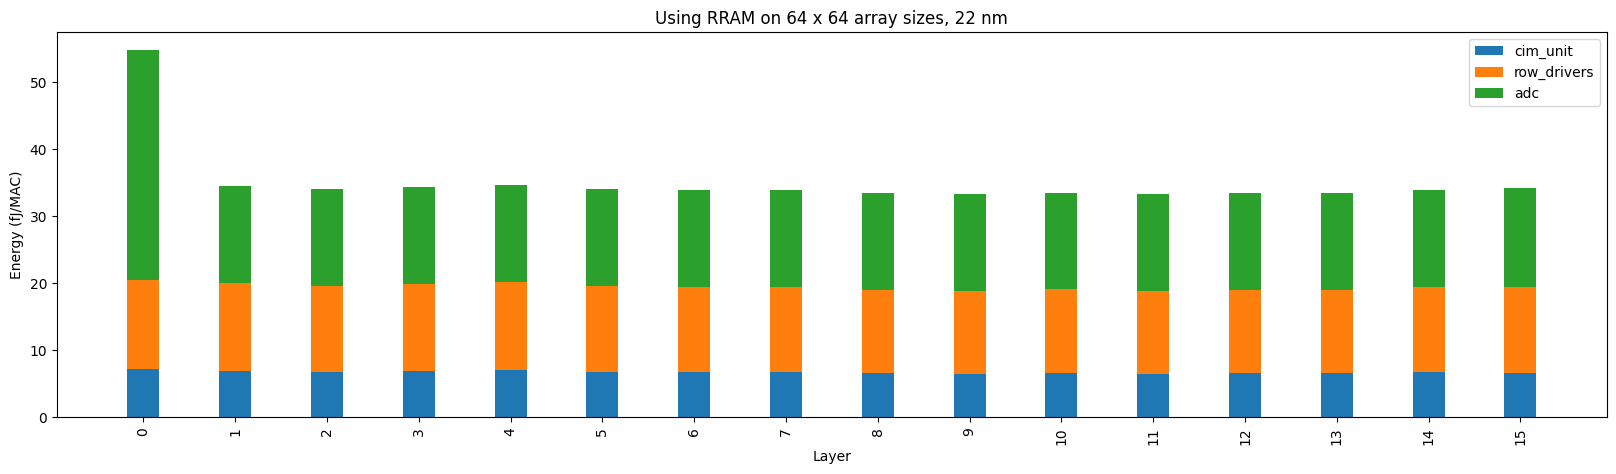

In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *
from scripts.tl_output_parsing import MacroOutputStats

MACRO_PATH = "../models/arch/1_macro/basic_analog/" 

display_markdown(
    """
### 64x64 Array Sizes, 22 nm

"""
)
array_sizes = 64
SRAM_PATH = 0
RRAM_PATH = f'"{os.path.abspath("../models/memory_cells/rram_example.cell.yaml")}"'
path = RRAM_PATH
macro = {}

def run_layer(dnn: str, layer: str, array_sizes: int, variables):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "basic_analog",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="ws_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # Use a larger array to ensure we can fit all weights
    spec.architecture.find("column").spatial.meshX = array_sizes
    spec.architecture.find("row").spatial.meshY = array_sizes

    spec.variables.update(variables)
    output_stats = run_mapper(spec)
    
    # Print computes for the layer
    macro_output_stats = MacroOutputStats.from_output_stats(output_stats)
    print(f"Computes: {macro_output_stats.computes}")
    global macro
    macro[layer] = macro_output_stats.computes
    return output_stats


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../models/workloads/")
    if os.path.isdir(f"../models/workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "vgg16"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers = sorted(layers)
print(f"Running: ", end="")

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = [run_layer(DNN, layer.split(".")[0]) for layer in layers]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0], array_sizes, 
                              {
                                  "CELL_CONFIG": path,
                                  "BITS_PER_CELL": 1 if path == SRAM_PATH else 4,
                                  "CIM_UNIT_WIDTH_CELLS": 4 if path == SRAM_PATH else 1,
                                  "IS_SRAM": path == SRAM_PATH,
                                  "TECHNOLOGY": 22,
                                  "ADC_RESOLUTION": 5
                              }
                             ) for layer in layers
)
print("")
for r in results:
    r.clear_zero_energies()

# Initialize overall_energy
energy_layer = [0] * 16
result = 0

total_per_energy_64 = [0] * 4

total_adc_energy = 0.0
total_col_energy = 0.0
total_row_energy = 0.0
total_cim_unit_energy = 0.0
# Calculate overall energy
for r in results:

    per_component_energy = r.per_compute("per_component_energy")
    total_energy_per_layer = sum(per_component_energy.values()) * 1e15  # Convert to fJ
    total_adc_energy += per_component_energy.get('adc', 0.0)
    total_col_energy += per_component_energy.get('column_drivers', 0.0)
    total_row_energy += per_component_energy.get('row_drivers', 0.0)
    total_cim_unit_energy += per_component_energy.get('cim_unit', 0.0)

    total_adc_energy = total_adc_energy * 1e15
    total_col_energy = total_col_energy * 1e15
    total_row_energy = total_row_energy * 1e15
    total_cim_unit_energy = total_cim_unit_energy * 1e15
    total_energy = total_adc_energy + total_col_energy + total_row_energy + total_cim_unit_energy

    total_adc_energy = total_adc_energy/total_energy
    total_col_energy = total_col_energy/total_energy
    total_row_energy = total_row_energy/total_energy
    total_cim_unit_energy = total_cim_unit_energy/total_energy
  
    total_per_energy_64[0] = total_adc_energy
    total_per_energy_64[1] = total_col_energy
    total_per_energy_64[2] = total_row_energy
    total_per_energy_64[3] = total_cim_unit_energy
    
# Display overall energy
print(f"Overall energy for DNN {DNN}: {total_energy} fJ")

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results)},
    title="Using RRAM on 64 x 64 array sizes, 22 nm",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

# 128x128 Array Size, 22 nm


### 128x128 Array Sizes, 22 nm



Available DNNs: ['vision_transformer', 'dpt_large', 'resnet18', 'mobilebert', 'msft_phi_1_5', 'gpt2_medium', 'vgg16', 'mobilenet_v3', 'alexnet', 'densenet201']
Running: 00 /home/workspace/scripts/../outputs/vgg16_128_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_128_RRAM_de/vgg16_128_RRAM_de_layer_1
Computes: 169344.0
01 /home/workspace/scripts/../outputs/vgg16_128_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_128_RRAM_de/vgg16_128_RRAM_de_layer_2
Computes: 3612672.0
02 /home/workspace/scripts/../outputs/vgg16_128_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_128_RRAM_de/vgg16_128_RRAM_de_layer_3
Computes: 1806336.0
03 /home/workspace/scripts/../outputs/vgg16_128_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_128_RRAM_de/vgg16_128_RRAM_de_layer_4
Computes: 3612672.0
04 /home/workspace/scripts/../outputs/vgg16_128_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_128_RRAM_de/vgg16_128_RRAM_de_

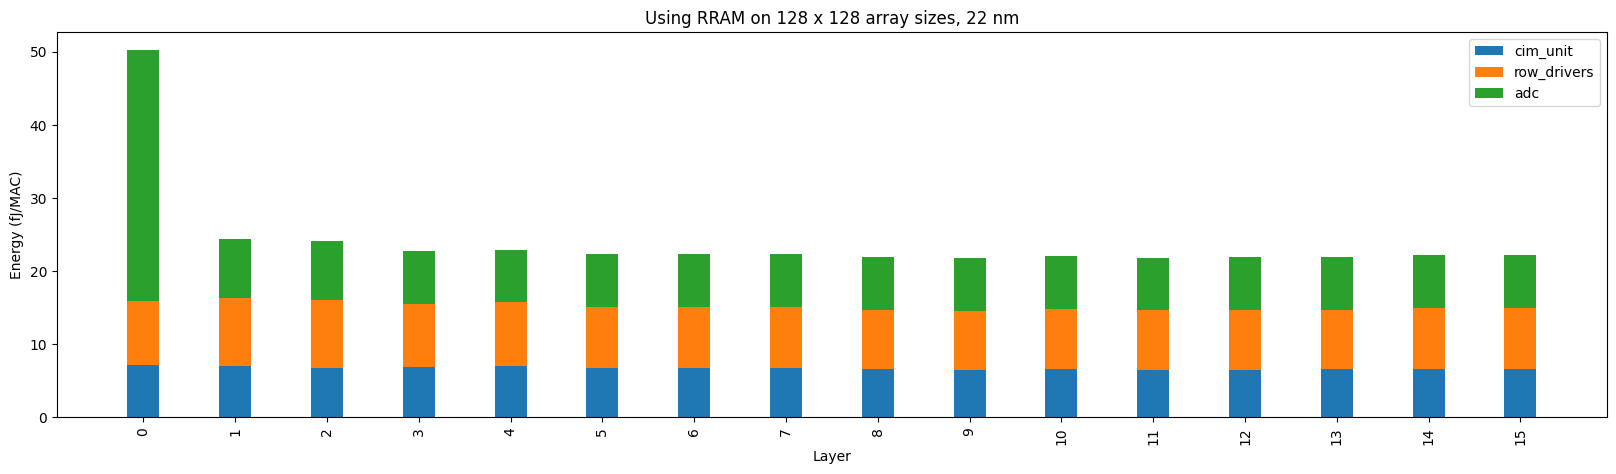

In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *
from scripts.tl_output_parsing import MacroOutputStats

MACRO_PATH = "../models/arch/1_macro/basic_analog/" 

display_markdown(
    """
### 128x128 Array Sizes, 22 nm

"""
)
array_sizes = 128
SRAM_PATH = 0
RRAM_PATH = f'"{os.path.abspath("../models/memory_cells/rram_example.cell.yaml")}"'
path = RRAM_PATH
macro = {}

def run_layer(dnn: str, layer: str, array_sizes: int, variables):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "basic_analog",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="ws_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # Use a larger array to ensure we can fit all weights
    spec.architecture.find("column").spatial.meshX = array_sizes
    spec.architecture.find("row").spatial.meshY = array_sizes

    spec.variables.update(variables)
    output_stats = run_mapper(spec)
    
    # Print computes for the layer
    macro_output_stats = MacroOutputStats.from_output_stats(output_stats)
    print(f"Computes: {macro_output_stats.computes}")
    global macro
    macro[layer] = macro_output_stats.computes
    return output_stats


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../models/workloads/")
    if os.path.isdir(f"../models/workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "vgg16"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers = sorted(layers)
print(f"Running: ", end="")

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = [run_layer(DNN, layer.split(".")[0]) for layer in layers]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0], array_sizes, 
                              {
                                  "CELL_CONFIG": path,
                                  "BITS_PER_CELL": 1 if path == SRAM_PATH else 4,
                                  "CIM_UNIT_WIDTH_CELLS": 4 if path == SRAM_PATH else 1,
                                  "IS_SRAM": path == SRAM_PATH,
                                  "TECHNOLOGY": 22,
                                  "ADC_RESOLUTION": 5
                              }
                             ) for layer in layers
)
print("")
for r in results:
    r.clear_zero_energies()

# Initialize overall_energy
energy_layer = [0] * 16
result = 0

total_per_energy_128 = [0] * 4

total_adc_energy = 0.0
total_col_energy = 0.0
total_row_energy = 0.0
total_cim_unit_energy = 0.0
# Calculate overall energy
for r in results:

    per_component_energy = r.per_compute("per_component_energy")
    total_energy_per_layer = sum(per_component_energy.values()) * 1e15  # Convert to fJ
    total_adc_energy += per_component_energy.get('adc', 0.0)
    total_col_energy += per_component_energy.get('column_drivers', 0.0)
    total_row_energy += per_component_energy.get('row_drivers', 0.0)
    total_cim_unit_energy += per_component_energy.get('cim_unit', 0.0)

    total_adc_energy = total_adc_energy * 1e15
    total_col_energy = total_col_energy * 1e15
    total_row_energy = total_row_energy * 1e15
    total_cim_unit_energy = total_cim_unit_energy * 1e15
    total_energy = total_adc_energy + total_col_energy + total_row_energy + total_cim_unit_energy

    total_adc_energy = total_adc_energy/total_energy
    total_col_energy = total_col_energy/total_energy
    total_row_energy = total_row_energy/total_energy
    total_cim_unit_energy = total_cim_unit_energy/total_energy
  
    total_per_energy_128[0] = total_adc_energy
    total_per_energy_128[1] = total_col_energy
    total_per_energy_128[2] = total_row_energy
    total_per_energy_128[3] = total_cim_unit_energy
    
# Display overall energy
print(f"Overall energy for DNN {DNN}: {total_energy} fJ")

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results)},
    title="Using RRAM on 128 x 128 array sizes, 22 nm",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

# 256x256 Array Size, 22 nm


### 256x256 Array Sizes, 22 nm



Available DNNs: ['vision_transformer', 'dpt_large', 'resnet18', 'mobilebert', 'msft_phi_1_5', 'gpt2_medium', 'vgg16', 'mobilenet_v3', 'alexnet', 'densenet201']
Running: 00 /home/workspace/scripts/../outputs/vgg16_256_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_256_RRAM_de/vgg16_256_RRAM_de_layer_1
Computes: 169344.0
01 /home/workspace/scripts/../outputs/vgg16_256_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_256_RRAM_de/vgg16_256_RRAM_de_layer_2
Computes: 3612672.0
02 /home/workspace/scripts/../outputs/vgg16_256_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_256_RRAM_de/vgg16_256_RRAM_de_layer_3
Computes: 1806336.0
03 /home/workspace/scripts/../outputs/vgg16_256_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_256_RRAM_de/vgg16_256_RRAM_de_layer_4
Computes: 3612672.0
04 /home/workspace/scripts/../outputs/vgg16_256_RRAM_de
Layer directory: /home/workspace/scripts/../outputs/vgg16_256_RRAM_de/vgg16_256_RRAM_de_

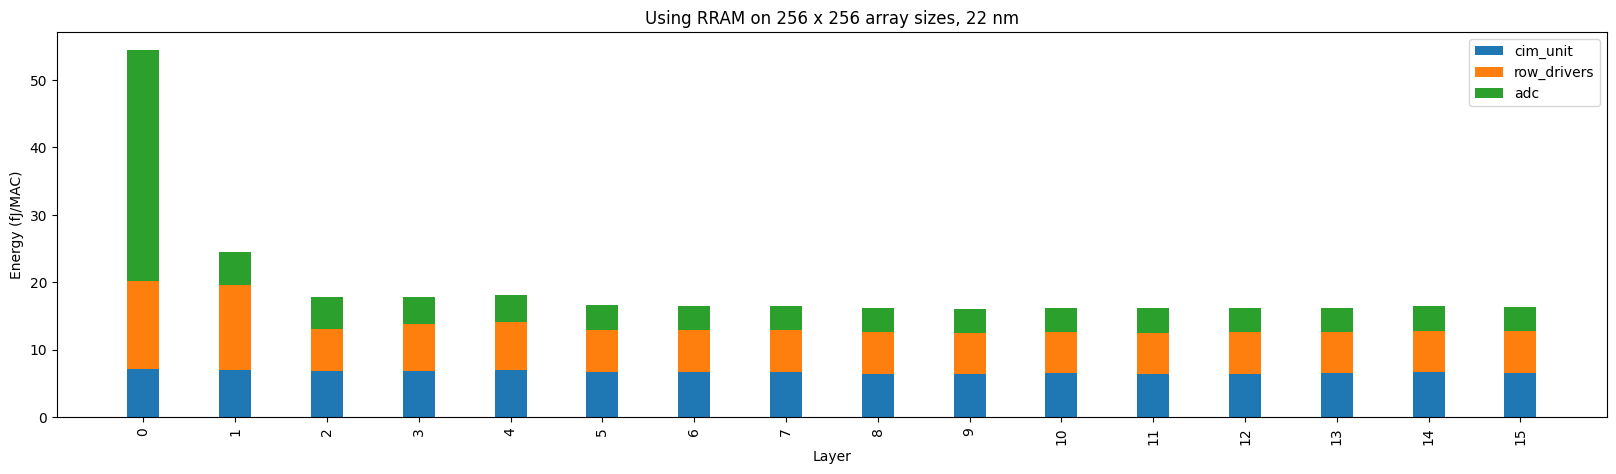

In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *
from scripts.tl_output_parsing import MacroOutputStats

MACRO_PATH = "../models/arch/1_macro/basic_analog/" 

display_markdown(
    """
### 256x256 Array Sizes, 22 nm

"""
)
array_sizes = 256
SRAM_PATH = 0
RRAM_PATH = f'"{os.path.abspath("../models/memory_cells/rram_example.cell.yaml")}"'
path = RRAM_PATH
macro = {}

def run_layer(dnn: str, layer: str, array_sizes: int, variables):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "basic_analog",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="ws_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # Use a larger array to ensure we can fit all weights
    spec.architecture.find("column").spatial.meshX = array_sizes
    spec.architecture.find("row").spatial.meshY = array_sizes

    spec.variables.update(variables)
    output_stats = run_mapper(spec)
    
    # Print computes for the layer
    macro_output_stats = MacroOutputStats.from_output_stats(output_stats)
    print(f"Computes: {macro_output_stats.computes}")
    global macro
    macro[layer] = macro_output_stats.computes
    return output_stats


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../models/workloads/")
    if os.path.isdir(f"../models/workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "vgg16"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers = sorted(layers)
print(f"Running: ", end="")

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = [run_layer(DNN, layer.split(".")[0]) for layer in layers]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0], array_sizes, 
                              {
                                  "CELL_CONFIG": path,
                                  "BITS_PER_CELL": 1 if path == SRAM_PATH else 4,
                                  "CIM_UNIT_WIDTH_CELLS": 4 if path == SRAM_PATH else 1,
                                  "IS_SRAM": path == SRAM_PATH,
                                  "TECHNOLOGY": 22,
                                  "ADC_RESOLUTION": 5
                              }
                             ) for layer in layers
)
print("")
for r in results:
    r.clear_zero_energies()

# Initialize overall_energy
energy_layer = [0] * 16
result = 0

total_per_energy_256 = [0] * 4

total_adc_energy = 0.0
total_col_energy = 0.0
total_row_energy = 0.0
total_cim_unit_energy = 0.0
# Calculate overall energy
for r in results:

    per_component_energy = r.per_compute("per_component_energy")
    total_energy_per_layer = sum(per_component_energy.values()) * 1e15  # Convert to fJ
    total_adc_energy += per_component_energy.get('adc', 0.0)
    total_col_energy += per_component_energy.get('column_drivers', 0.0)
    total_row_energy += per_component_energy.get('row_drivers', 0.0)
    total_cim_unit_energy += per_component_energy.get('cim_unit', 0.0)

    total_adc_energy = total_adc_energy * 1e15
    total_col_energy = total_col_energy * 1e15
    total_row_energy = total_row_energy * 1e15
    total_cim_unit_energy = total_cim_unit_energy * 1e15
    total_energy = total_adc_energy + total_col_energy + total_row_energy + total_cim_unit_energy

    total_adc_energy = total_adc_energy/total_energy
    total_col_energy = total_col_energy/total_energy
    total_row_energy = total_row_energy/total_energy
    total_cim_unit_energy = total_cim_unit_energy/total_energy
  
    total_per_energy_256[0] = total_adc_energy
    total_per_energy_256[1] = total_col_energy
    total_per_energy_256[2] = total_row_energy
    total_per_energy_256[3] = total_cim_unit_energy
    
# Display overall energy
print(f"Overall energy for DNN {DNN}: {total_energy} fJ")

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results)},
    title="Using RRAM on 256 x 256 array sizes, 22 nm",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

In [2]:
print(total_per_energy_32)

[0.5372894947874656, 0.0, 0.3512429831596028, 0.11146752205293169]


In [2]:
print(total_per_energy_64)

[0.6261682242989652, 0.0, 0.24392523364492613, 0.12990654205610866]


In [2]:
print(total_per_energy_128)

[0.683673469387635, 0.0, 0.17551020408170065, 0.14081632653066448]


In [2]:
print(total_per_energy_256)

[0.6302916274693214, 0.0, 0.2398871119473578, 0.12982126058332089]


In [3]:
from _import_scripts import scripts
from scripts.notebook_utils import *
from scripts.tl_output_parsing import MacroOutputStats
total_area = [0] * 4
total_adc_area = [0] * 4
total_col_area = [0] * 4
total_row_area = [0] * 4
total_cim_unit_area = [0] * 4
total_macro = [0] * 4
energy = [0] * 4
throughput = [0] * 4
total_area[0], total_adc_area[0], total_col_area[0], total_row_area[0], total_cim_unit_area[0], total_macro[0], energy[0], throughput[0] = extract_outputs("vgg16_32_RRAM_de")
total_area[1], total_adc_area[1], total_col_area[1], total_row_area[1], total_cim_unit_area[1], total_macro[1], energy[1], throughput[1] = extract_outputs("vgg16_64_RRAM_de")
total_area[2], total_adc_area[2], total_col_area[2], total_row_area[2], total_cim_unit_area[2], total_macro[2], energy[2], throughput[2] = extract_outputs("vgg16_128_RRAM_de")
total_area[3], total_adc_area[3], total_col_area[3], total_row_area[3], total_cim_unit_area[3], total_macro[3], energy[3], throughput[3] = extract_outputs("vgg16_256_RRAM_de")

../outputs/vgg16_32_RRAM_de/
Model 	 Energy/inference (J) 	 Area (mm2) 	 Throughput (inf/s)
Processing layer: vgg16_32_RRAM_de_layer_1
Size: 4
All macro: 4
adc area: 12441.546372, number of adc: 4096, 
total adc area: (12441.546372*4096/4096) * macro = 49766.185488

Size: 4
All macro: 4
column drivers area: 52.11191, number of column_drivers: 4096, 
total column drivers area: (52.11191*4096/4096) * macro = 208.44764

Size: 4
All macro: 4
row drivers area: 59.55647, number of row_drivers: 4096, 
total row drivers area: (59.55647*4096/4096) * macro = 238.22588

Size: 4
All macro: 4
cim unit area: 0.01936, number of cim_unit: 4194304, 
total cim unit area: (0.01936*4194304/4096) * macro = 79.29856

Total Area for layer 1: 50292.157568

Total Macro for layer 1: 4

Total Area for all layers: 50292.157568
Total Area for ADC across all layers: 49766.185488
Processing layer: vgg16_32_RRAM_de_layer_2
Size: 3
Size: 3
Size: 4
All macro: 36
adc area: 12441.546372, number of adc: 4096, 
total adc a

In [4]:
print(total_area)
print(total_adc_area)
print(total_col_area)
print(total_row_area)
print(total_cim_unit_area)
print(total_macro)
print(energy)
print(throughput)

[325.49084378009604, 185.817450666, 111.03601923882, 82.12881870135001]
[322.08675247833594, 181.91345581199997, 105.97157612262, 73.37221666335]
[1.3490731260800002, 1.3444870199999996, 1.382007588, 1.688425965]
[1.5417978953599996, 1.5365564099999998, 1.5794377169999998, 1.929629385]
[0.5132202803199999, 1.022951424, 2.1029978112, 5.138546687999999]
[25888, 12900, 6630, 4050]
[0.0008842079999999999, 0.0005264769999999998, 0.00035196409999999995, 0.0002766432000000001]
[44.50715007365933, 61.46319276701147, 68.02443437682815, 71.45562248565528]


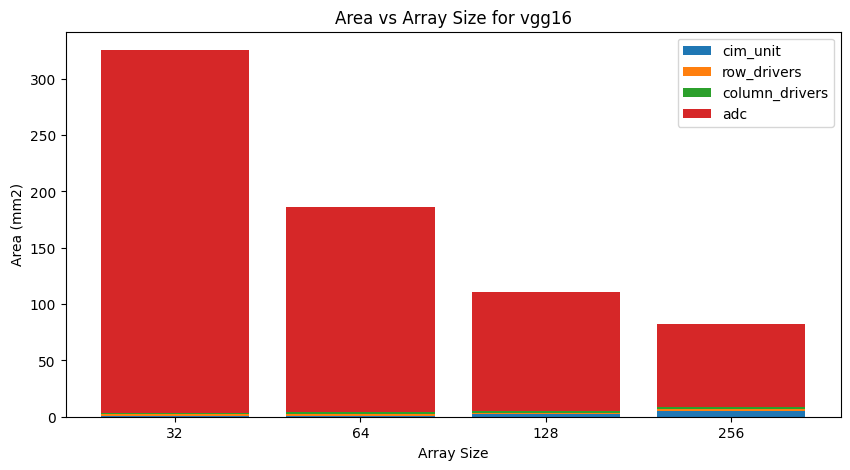

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10, 5)) 
array_sizes = ['32', '64', '128', '256']

x = np.arange(len(array_sizes))

# Stack bars
ax.bar(array_sizes, total_cim_unit_area, label='cim_unit')
ax.bar(array_sizes, total_row_area, bottom=total_cim_unit_area, label='row_drivers')
ax.bar(array_sizes, total_col_area, bottom=np.array(total_cim_unit_area) + np.array(total_row_area), label='column_drivers')
ax.bar(array_sizes, total_adc_area, bottom=np.array(total_cim_unit_area) + np.array(total_row_area) + np.array(total_col_area), label='adc')

# Labels and title
ax.set_title("Area vs Array Size for vgg16")
ax.set_xlabel("Array Size")
ax.set_ylabel("Area (mm2)")
# Set x-ticks
ax.set_xticks(x)
ax.set_xticklabels(array_sizes)

ax.legend()

# Show plot
plt.show()

In [12]:
total_per_energy_32 = [0.5372894947874656, 0.0, 0.3512429831596028, 0.11146752205293169]
total_per_energy_64 = [0.6261682242989652, 0.0, 0.24392523364492613, 0.12990654205610866]
total_per_energy_128 = [0.683673469387635, 0.0, 0.17551020408170065, 0.14081632653066448]
total_per_energy_256 = [0.6302916274693214, 0.0, 0.2398871119473578, 0.12982126058332089]

In [13]:
total_adc_energy = [0] * 4
total_col_energy = [0] * 4
total_row_energy = [0] * 4
total_cim_unit_energy = [0] * 4
for j in range(len(energy)):
    if j == 0:
        for i in range(len(total_per_energy_32)):
            if i == 0:
                total_adc_energy[j] = total_per_energy_32[i] * energy[j]
            elif i == 1:
                total_col_energy[j] = total_per_energy_32[i] * energy[j]
            elif i == 2:
                total_row_energy[j] = total_per_energy_32[i] * energy[j]
            else:
                total_cim_unit_energy[j] = total_per_energy_32[i] * energy[j]
    elif j == 1:
        for i in range(len(total_per_energy_64)):
            if i == 0:
                total_adc_energy[j] = total_per_energy_64[i] * energy[j]
            elif i == 1:
                total_col_energy[j] = total_per_energy_64[i] * energy[j]
            elif i == 2:
                total_row_energy[j] = total_per_energy_64[i] * energy[j]
            else:
                total_cim_unit_energy[j] = total_per_energy_64[i] * energy[j]

    elif j == 2:
        for i in range(len(total_per_energy_128)):
            if i == 0:
                total_adc_energy[j] = total_per_energy_128[i] * energy[j]
            elif i == 1:
                total_col_energy[j] = total_per_energy_128[i] * energy[j]
            elif i == 2:
                total_row_energy[j] = total_per_energy_128[i] * energy[j]
            else:
                total_cim_unit_energy[j] = total_per_energy_128[i] * energy[j]

    else:
        for i in range(len(total_per_energy_256)):
            if i == 0:
                total_adc_energy[j] = total_per_energy_256[i] * energy[j]
            elif i == 1:
                total_col_energy[j] = total_per_energy_256[i] * energy[j]
            elif i == 2:
                total_row_energy[j] = total_per_energy_256[i] * energy[j]
            else:
                total_cim_unit_energy[j] = total_per_energy_256[i] * energy[j]
                
print(total_adc_energy)
print(total_col_energy)
print(total_row_energy)
print(total_cim_unit_energy)

[0.00047507566960703533, 0.0003296631682242462, 0.00024062851734689644, 0.00017436589275632105]
[0.0, 0.0, 0.0, 0.0]
[0.00031057185565358606, 0.00012842102523367974, 6.177329102043208e-05, 6.636313828787532e-05]
[9.856047473937862e-05, 6.83928065420739e-05, 4.956229163267144e-05, 3.591416895580377e-05]


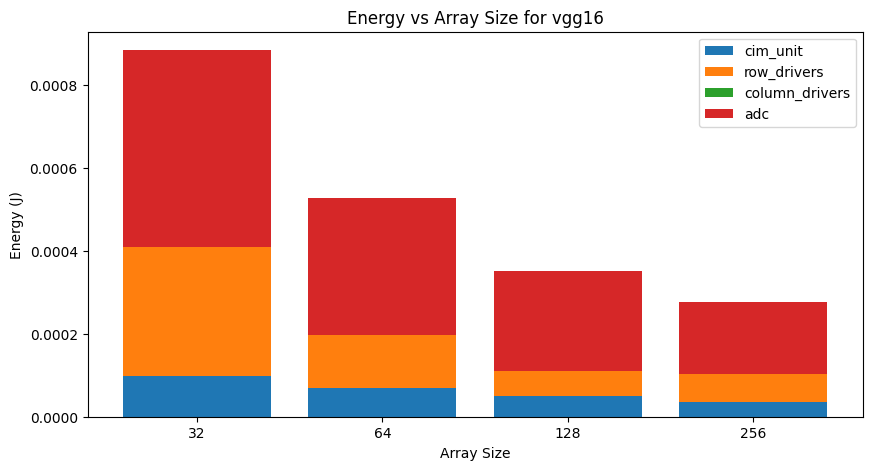

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10, 5)) 
array_sizes = ['32', '64', '128', '256']

x = np.arange(len(array_sizes))

# Stack bars
ax.bar(array_sizes, total_cim_unit_energy, label='cim_unit')
ax.bar(array_sizes, total_row_energy, bottom=total_cim_unit_energy, label='row_drivers')
ax.bar(array_sizes, total_col_energy, bottom=np.array(total_cim_unit_energy) + np.array(total_row_energy), label='column_drivers')
ax.bar(array_sizes, total_adc_energy, bottom=np.array(total_cim_unit_energy) + np.array(total_row_energy) + np.array(total_col_energy), label='adc')

# Labels and title
ax.set_title("Energy vs Array Size for vgg16")
ax.set_xlabel("Array Size")
ax.set_ylabel("Energy (J)")
# Set x-ticks
ax.set_xticks(x)
ax.set_xticklabels(array_sizes)

ax.legend()

# Show plot
plt.show()

In [15]:
print(energy)

[0.0008842079999999999, 0.0005264769999999998, 0.00035196409999999995, 0.0002766432000000001]


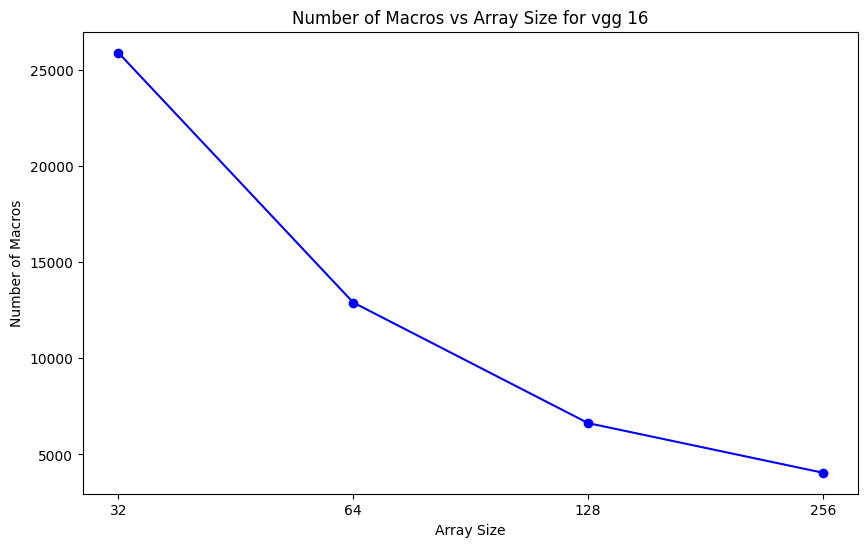

In [10]:
import matplotlib.pyplot as plt

# Data
array_sizes = ['32', '64', '128', '256']
x = np.arange(len(array_sizes))
# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(array_sizes, total_macro, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Array Size')
plt.ylabel('Number of Macros')
plt.title('Number of Macros vs Array Size for vgg 16')
plt.grid(False)
plt.xticks(x, array_sizes) 
# Show plot
plt.show()

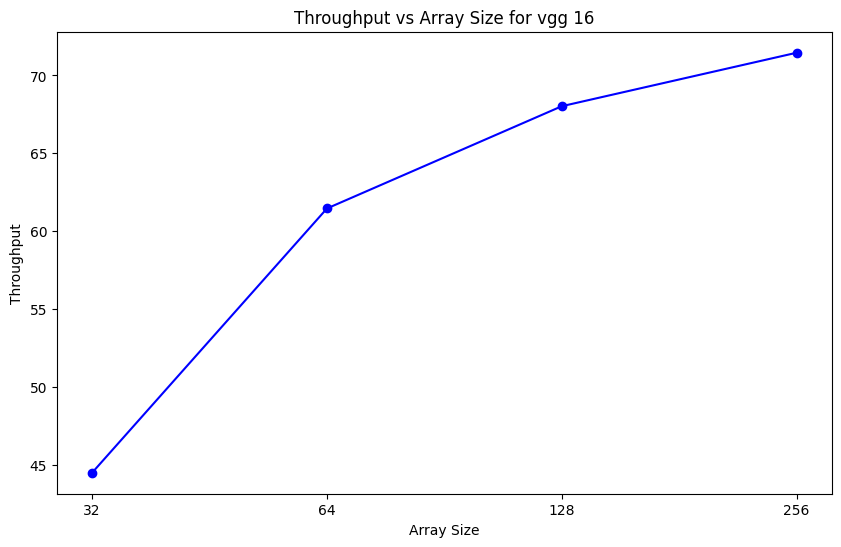

In [11]:
import matplotlib.pyplot as plt

# Data
array_sizes = ['32', '64', '128', '256']
x = np.arange(len(array_sizes))
# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(array_sizes, throughput, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Array Size')
plt.ylabel('Throughput')
plt.title('Throughput vs Array Size for vgg 16')
plt.grid(False)
plt.xticks(x, array_sizes) 
# Show plot
plt.show()